## 新想法
1. 每日更新股價資料檔案（已完成）   
    a. 每日收盤時執行  
    b. 更新當天的收盤資訊


2. 每日收盤時執行並判斷（預先設定好要關注的標的）  
    a. 爬取當天收盤資訊並分析  
    b. 出現明確買賣點透過line回傳  
    c. 分析該檔股價的權證資料  
    d. 篩選出適合的權證標的  


3. 關於分析收盤資訊（技術分析）  
    a. 布林通道策略  
        i. 窄寬通道的判斷  
        ii. 上下軌道斜率判斷  
        iii. Ｋ棒突破、成交量判斷。
    b. 三大法人的成交量（外資）  
    c. 記錄交易資訊與判斷資訊  
    
    
4. 關於分析權證資訊

<bound method NDFrame.head of               Open    High     Low   Close  Volume
Date                                              
2022-08-12  120.55  121.00  120.30  120.80    8598
2022-08-15  121.45  122.10  121.25  121.90    9837
2022-08-16  122.00  122.30  121.90  122.10   10114
2022-08-17  122.10  122.30  121.80  122.15   14115
2022-08-18  121.40  121.45  120.95  121.35    5638
2022-08-19  121.25  122.00  120.90  121.55    4316>


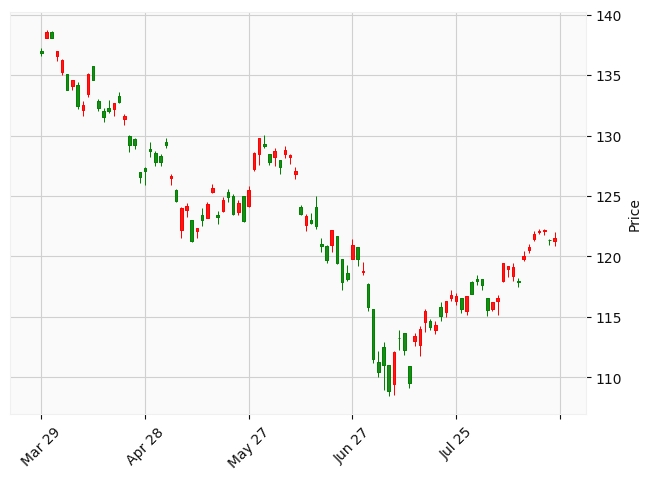

In [3]:
# 基本繪圖: K線圖
import pandas as pd
import mplfinance as mpf
# 讀取股票檔案，最新100筆資料
SData = pd.read_csv('0050.csv',index_col='Date').iloc[-100:,:]
# 更改時間格式
SData.index = pd.DatetimeIndex(SData.index)
print(SData.iloc[-6:,:].head)
mc = mpf.make_marketcolors(up='r', down='g', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)
mpf.plot(SData, type='candle', style =s)

## 建立布林通道函式
1. 布林通道的定義為，K為標準差數量，N為過去幾筆資料:  
        中軌 = N時間段的簡單移動平均線  
        上軌 = 中軌 + K * N時間段的標準差  
        下軌 =  中軌 - K * N時間段的標準差  
2. 圖中藍線是上軌、橘線是中軌、綠色是下軌，常用的計算方式為N = 20、K = 2，也就是說中軌的每個點都是前20筆價格的平均  
3. 標準差的計算方式為N時間段的每筆數值減去平均值的平方和再除以N後開根號，計算出來的標準差代回到布林通道的公式中就可以得到上下軌

In [5]:
def BBands(data, period=20, std_num=2): 
    res = data.copy(deep=True)                                   # 取得data資料
    res['b_mid'] = data['Close'].rolling(period).mean()          # 計算中線(20日均線)
    std = data['Close'].rolling(period).std(ddof=0)              # 計算用於上下軌的標準差
    res['b_up'] = res['b_mid'] + std * std_num                   # 計算上軌
    res['b_low'] = res['b_mid'] - std * std_num                  # 計算下軌
    return res

### 繪製簡易布林通道

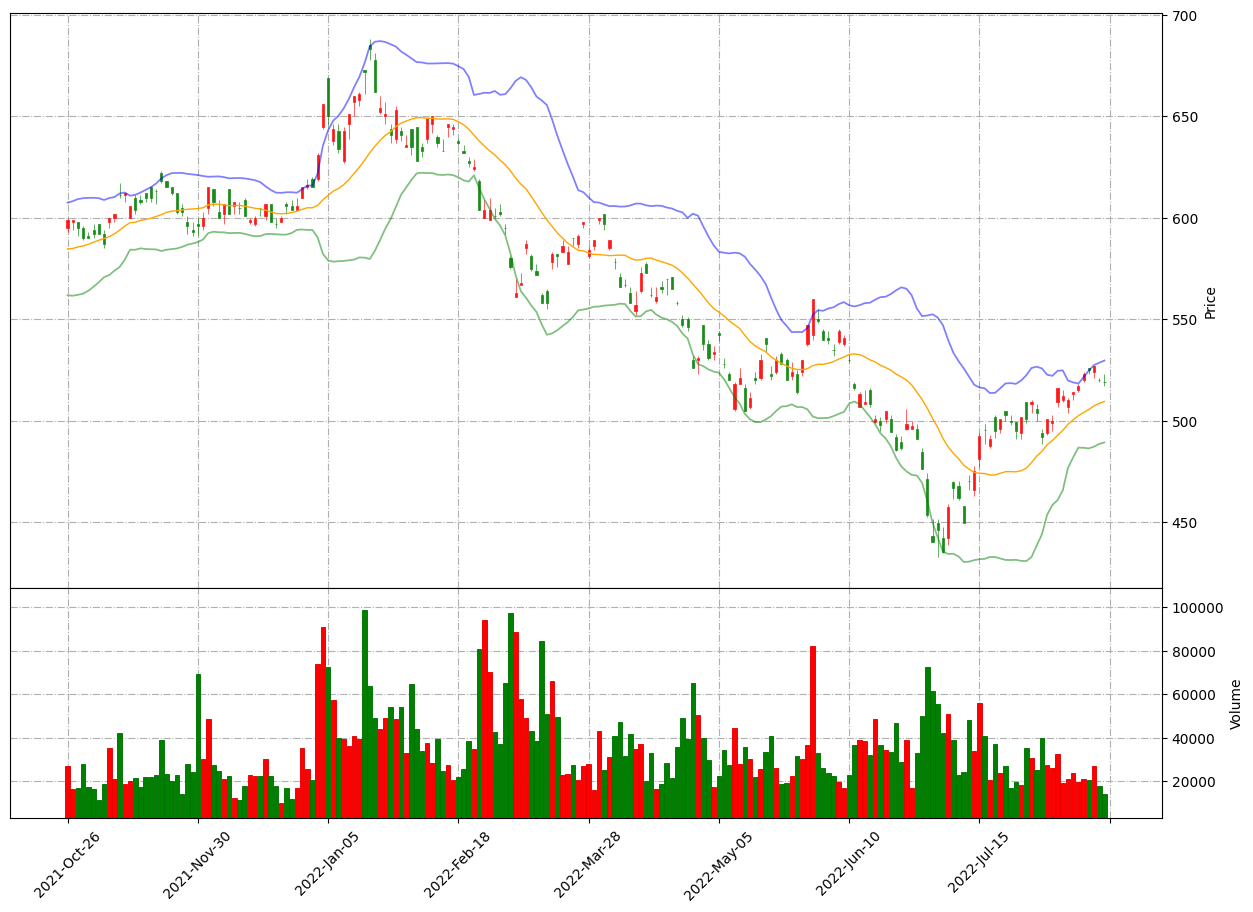

In [14]:
# 繪製簡易布林通道
import numpy as np
import mplfinance as mpf

SData = pd.read_csv('2330.csv',index_col='Date')       # 讀取股價檔案
SData.index = pd.DatetimeIndex(SData.index)            # 更改時間格式
bbands_data = BBands(SData)                            # 將股價資訊經過BBands函式計算
day_num = 200                                          # 設定顯示股價資訊的天數

# 繪製布林通道線圖
addplots = [
            mpf.make_addplot(bbands_data['b_mid'][-day_num:], panel=0, color='orange', alpha=1, width=1, secondary_y=False),
            mpf.make_addplot(bbands_data['b_up'][-day_num:], color = 'blue', alpha=0.5),
            mpf.make_addplot(bbands_data['b_low'][-day_num:], color = 'green', alpha=0.5)
           ]

# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',              # 上漲顏色
                                 down='green',          # 下跌顏色
                                 edge='i',              # 隱藏 K 線邊緣
                                 volume='in',           # 成交量用同樣的顏色
                                 inherit=True)          # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色

kwargs = dict(type = 'candle', 
              figscale = 2,                             # 設定圖型大小
              style = my_style)

_panel = 2
mpf.plot(SData.iloc[-day_num:,:],
         **kwargs,
         num_panels=_panel,           # 設定總層數
         main_panel=0,                # 設定 K 線圖層數
         volume=True,                 # 設定是否繪製成交量 
         volume_panel=_panel - 1,     # 設定成交量層數             
         show_nontrading=False,       # 忽略非交易日
         tight_layout=False,          # 設定布局方式
         addplot = addplots)

## 更新布林通道函式:

    新增計算 上軌斜率、中線斜率、通道寬度並更新到股價數據檔案中!
    斜率(%): 是看漲多少，而非角度
    a. 上軌斜率: (當日上軌數值/前日上軌數值) - 1 * 100(%)
    b. 中線斜率: (當日中線數值/前日中線數值) - 1 * 100(%)
    c. 通道寬度: (當日上軌數值/當日下軌數值) - 1 * 100(%)

In [15]:
def BBands(data, period=20, std_num=2): 
    
    # 計算布林通道 上軌、中線與下軌:
    res = data.copy(deep=True)                                               # 複製 data資料
    res['b_mid'] = data['Close'].rolling(period).mean()                      # 計算中線(20日均線)
    std = data['Close'].rolling(period).std(ddof=0)                          # 計算用於上下軌的標準差
    res['b_up'] = res['b_mid'] + std * std_num                               # 計算上軌
    res['b_low'] = res['b_mid'] - std * std_num                              # 計算下軌
    
    # 計算布林通道 上軌斜率、中線斜率、通道寬度:
    b_slope = [np.nan]
    ma_slope = [np.nan]
    b_width = [np.nan]
    t = res.index
    for i in range(1, len(res)):  
        b_slope.append((res.loc[t[i], 'b_up']-res.loc[t[i-1], 'b_up'])/res.loc[t[i-1], 'b_up'] * 100)      # 計算布林通道上軌斜率
        ma_slope.append((res.loc[t[i], 'b_mid']/res.loc[t[i-1], 'b_mid']-1) * 100)   # 計算中線斜率
        b_width.append((res.loc[t[i], 'b_up']/res.loc[t[i], 'b_low']-1) * 100)       # 計算布林通道寬度
    res['bband_slope'] = b_slope
    res['bband_width'] = b_width
    res['mid_slope'] = ma_slope
    return res

https://www.youtube.com/watch?v=NF2Fwa99i0o
### a.布林通道策略: 說明策略的想法，並實際計算績效
1. 帶寬判斷
    1. 突破上下軌道(5%以下)
    2. 區間震盪(20%以上)
2. 完成不同策略的判斷、並畫出買賣點
3. 分析此策略的績效並改進

離開上軌可以部份停利

月線(斜率0.4%以上):
    可以不用看帶寬
    多頭: 股價在上通道跟月線(斜率0.4%以上)間震盪

In [58]:
# 測試計算 當前購買平均股價
table = [
            ['日期', '買/賣(+/-)', '成交價', '價格(稅)', '實際花費', '目前獲利', '剩餘金額', '報酬率%'],
            ['2021-07-13','+100',48.1,48.1*1.000855,'-187800','-187800','312200','-'],
            ['2021-07-13','+100',47.4,47.4*1.000855,'-187800','-187800','312200','-']
         ]
df = pd.DataFrame(table[1:],columns=table[0])
buy_temp = df[df['買/賣(+/-)'].str.startswith('+')]                # 過濾出只有買進的交易資訊
t = buy_temp.loc[0:5][['買/賣(+/-)','價格(稅)']].iloc[::-1]
print(t)
temp_stock = 200
cost = 0
for i in t.values:
    
    num = int(i[0].strip('+'))
    temp_stock-=num
    if temp_stock>=0:
        cost += round(num * i[1])
print('總花費:',cost)
print('平均每股價格：', cost/200)

  買/賣(+/-)      價格(稅)
1     +100  47.440527
0     +100  48.141126
總花費: 9558
平均每股價格： 47.79


In [59]:
# avg_cost : 計算當前購買平均成本
"""
    input: 
        df:股價交易資訊(detail), stock:目前庫存張數, info:是否顯示數據
    return:
        當前購買平均成本
"""
def avg_cost(df,stock, info=False):
    buy_only = df[df['買/賣(+/-)'].str.startswith('+')]                # 過濾出只有買進的交易資訊
    data = buy_only[['買/賣(+/-)','價格(稅)']].iloc[::-1]              # 將交易資訊翻轉(由後往前看)
    temp_stock = stock
    cost = 0
    for i in data.values:
        num = int(i[0].strip('+'))
        temp_stock-=num
        if temp_stock>=0:
            cost += round(num * i[1])                                 # 累積每股買入持有成本
        else:
            break
    if info:
        print(data)
        print('當前持有成本為:',cost)
        print('可下單股數為:',stock)
    print('平均每股價格：', round(cost/stock,2))
    return round(cost/stock,2)

In [60]:
def BBands(data, period=20, std_num=2):
    res = data.copy(deep=True)                                   # 取得data資料
    res['b_mid'] = data['Close'].rolling(period).mean()          # 計算中線(20日均線)
    std = data['Close'].rolling(period).std(ddof=0)              # 計算用於上下軌的標準差
    res['b_up'] = res['b_mid'] + std * std_num                   # 計算上軌
    res['b_low'] = res['b_mid'] - std * std_num                  # 計算下軌
    b_slope = [np.nan]
    ma_slope = [np.nan]
    b_width = [np.nan]
    t = res.index
    for i in range(1, len(res)):
        slope = (res.loc[t[i], 'b_up']/res.loc[t[i-1], 'b_up']-1) * 100        # 計算布林通道上軌斜率
        b_slope.append(slope)
        slope = (res.loc[t[i], 'b_mid']/res.loc[t[i-1], 'b_mid']-1) * 100    # 計算中線斜率
        ma_slope.append(slope)
        width = (res.loc[t[i], 'b_up']/res.loc[t[i], 'b_low']-1) * 100         # 計算布林通道寬度
        b_width.append(width)
    res['bband_slope'] = b_slope
    res['bband_width'] = b_width
    res['mid_slope'] = ma_slope
    return res

## 建立回測規則函式

In [71]:
def update(detail,day,dec,close,price,buy,gain,money,stock):
    temp_detail = []
    temp_detail.append(day)                                                        #交易日期
    temp_detail.append(dec)                                                        #買賣 num股
    temp_detail.append(close)                                                      #成交價格: "收盤價"
    temp_detail.append(price)                                                      #持有成本(含稅)
    temp_detail.append(buy)                                                        #實際花費 buy元
    temp_detail.append(gain)                                                       #目前獲利
    temp_detail.append(money)                                                      #剩餘金額
    if dec[0]=='+':
        stock += int(dec[1:])
    else:
        stock -= int(dec[1:])
    temp_detail.append(stock)                                                      #更新庫存張數
    detail.append(temp_detail)                                                     #紀錄交易資訊至正是表格中
    detail_pd = pd.DataFrame(detail[1:],columns=detail[0])                         #將交易記錄製作成 DataFrame 
    return detail_pd,stock

In [72]:
import math
import pandas as pd

# 記錄買賣資訊 
def buy_or_sell(day, decide, close, type_=1):
    global money, gain, buy, detail, stock, buy_unit, sell_unit, price, detail_pd, avg_price
    
    if decide == 'buy' and  money > 0 : 
        price = round(close * 1.001425, 1)                                             #計算含稅的股價
        
        if type_ == 1:                                                                 # type_1: 分段進場
            num = math.floor(buy_unit/price)                                           # 計算分段進場能購買的股數
            if (money- round(num*price)) > 0:                                              
                num = num                                                                 
            else:
                num = math.floor(money/price) 
        elif type_ == 2:                                                               # type_2: 全數進場
            num = math.floor(money/price)                                              # 計算剩餘金額能購買的股數
        
        buy = round(num*price)                                                         #計算實際花費
        money = money-buy                                                              #更新 money
        gain -= buy                                                                    #計算淨收益(含稅)
        detail_pd,stock = update(detail,day,'+' + str(num),close,price,'-' + str(buy),gain,money,stock)
        sell_unit = round(stock/5)                                                     #更新每次賣出單位
        
    elif decide == 'sell':       
        price = round(close * 0.995575)                                                #計算含稅的股價 
        
        if type_ == 1:                                                                 # type_1: 分段出場
            if (stock - sell_unit) > 0:                                                #計算購買股數
                num = sell_unit                                                                 
            else:
                num = stock
        elif type_ == 2:                                                               # type_2: 全數出場
            print(day,'全數出場!')
            num = stock   
        
        sell = round(close * 0.995575 * num)                                           # 計算實際收入
        money = money + sell                                                           # 更新 money
        gain += sell                                                                   # 淨收益計算
        detail_pd,stock = update(detail,day,'-' + str(num),close,price,'+' + str(buy),gain,money,stock)
        buy_unit = round(money/5)                                                      #更新每次進場金額
        
    elif decide == 'over':
        sell = round(close * 0.995575 * stock)                                         # 計算實際收入
        money = money + sell                                                           # 更新 money
        gain += sell                                                                   # 淨收益計算
        num = stock                                                                    #將持有的股數全數出清
        detail_pd,stock = update(detail,day,'-' + str(num),close,round(close * 0.995575),'+' + str(buy),gain,money,stock)
    

In [100]:
import numpy as np
def bbands_rule(_ticker, bb_period=20, bb_stdnum=2, use_detail=False):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
  
    # 檢查使否存在要用的指標
    try:
        if not {'b_mid', 'b_up', 'b_low'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
    except Exception as e:
        print(e)
        return False

    temp = 494.0 * 0.01                                                                # 設定買賣點的距離
    buy_1 = [np.nan]*len(res)
    buy_2 = [np.nan]*len(res)
    sell_1 = [np.nan]*len(res)
    w_15 = [np.nan]*len(res)
    w_10 = [np.nan]*len(res)
    sell_2 = [np.nan]*len(res)
    new_price = 0                                                                          # 最後進場價格
    buy2 = False                                                                           # 策略二是否進場

    # 取得 index 值(日期)，方便計算使用
    t = res.index

    for i in range(1, len(res)):
        decide = ''
        trade_type = 1                                                                     # 預設交易模式: 分段進出場
        width = res.loc[t[i], 'bband_width']
        slope2 = res.loc[t[i], 'mid_slope']
        # 計算是否符合買進條件
        if width > 15:                                                                     # 策略一: 通道寬度大於15%
            w_15[i] = res.loc[t[i], 'b_low']
            if res.loc[t[i], 'Low'] < res.loc[t[i], 'b_low']:                              # K棒碰觸到下軌
                buy_1[i] = res.loc[t[i], 'Low'] - temp                                     # 標示座標點(深藍色)
                decide = 'buy'
   
        elif width <= 10:                                                                  # 策略二: 通道寬度小於10%
            w_10[i] = res.loc[t[i], 'b_low']                                                                
            if (res.loc[t[i], 'Close'] > res.loc[t[i], 'Open']) and res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:
                buy_2[i] = res.loc[t[i], 'Low'] - temp                                     # 標示座標點(淡藍色)
                new_price = res.loc[t[i], 'Close']
                #print(t[i],'buy2:',slope2,'close:',res.loc[t[i], 'Close'])
                decide = 'buy'
                if slope2 > 0.05:                                                         # 如果20日均線斜率>5%
                    trade_type = 2                                                        # 剩餘金額全數進場
                buy2 = True
                
        # 計算是否符合做空首要條件
        if ((res.loc[t[i], 'b_up']/res.loc[t[i], 'b_low']-1) * 100) > 15: # 通道寬度大於15%
            if res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:                            # 收盤價突破上軌
                sell_1[i] = res.loc[t[i], 'High'] + temp
                decide = 'sell'
                buy2 = False
        if buy2 and new_price < res.loc[t[i], 'Close']:
            #print(t[i],bbands_data.loc[t[i], 'b_up'],res.loc[t[i], 'Close'])             # 判斷股價是否離開上軌
            if res.loc[t[i], 'Close'] < res.loc[t[i], 'b_up'] :
                sell_2[i] = res.loc[t[i], 'High'] + temp
                #decide = 'sell'
                if slope2 < 0.05:                                                         # 如果20日均線斜率 < 5%
                    trade_type = 2                                                        # 剩餘金額全數出場
                buy2 = False
        
        if use_detail:
            buy_or_sell(t[i].date(), decide, res.loc[t[i], 'Close'],trade_type)                         # 記錄交易資訊
    
    if use_detail:
        decide = 'over'                                                                      #將持有的股數全數出清
        buy_or_sell(t[i].date(), decide, res.loc[t[i], 'Close'])        
    
    res['buy_point'] = buy_1
    res['buy2_point'] = buy_2
    res['sell_point'] = sell_1
    res['sell2_point'] = sell_2
    res['w_15'] = w_15
    res['w_10'] = w_10
    
    return res

## 關於新增線圖的設定(官方文檔)
https://github.com/matplotlib/mplfinance/blob/master/examples/addplot.ipynb

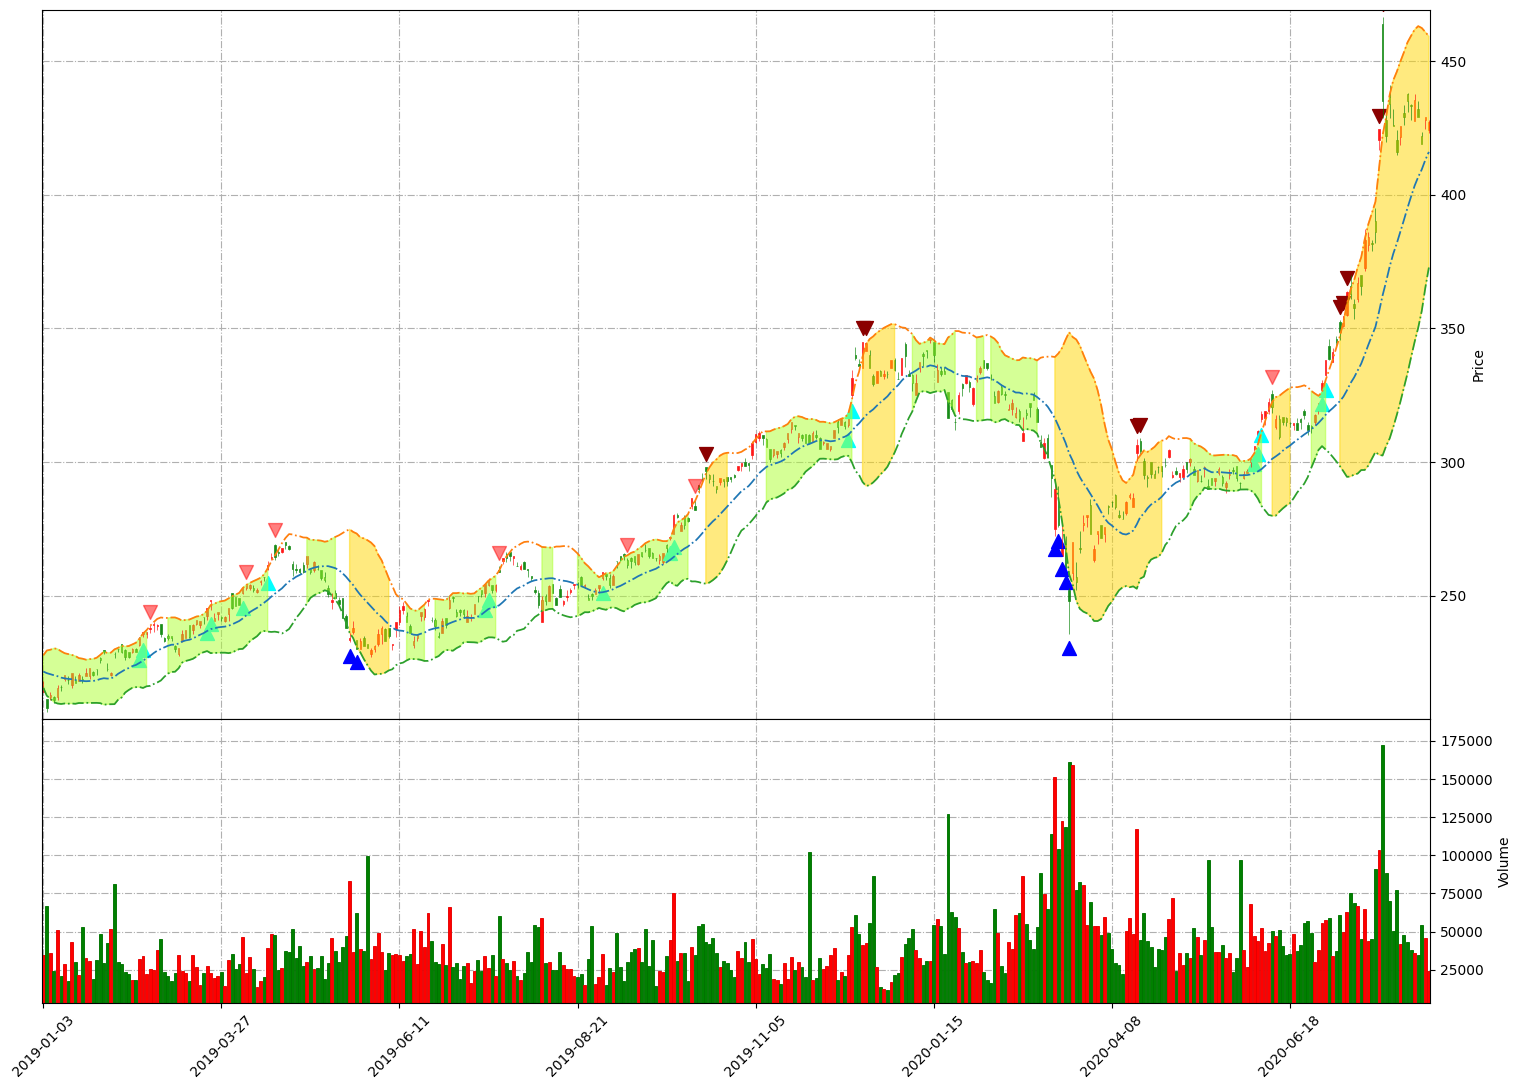

In [101]:
# 設定讀取股票資料
import mplfinance as mpf
path = "C:/Users/Landis/Desktop/pystocks"
s = '2330.csv'
SData = pd.read_csv(path+'/'+s,index_col='Date')
SData.index = pd.DatetimeIndex(SData.index) 
# range
day_num = '2019-01-03'                        # 設定顯示股價資訊起始日期
day_end = '2020-08-15'                        # 設定顯示股價資訊結束日期

detail = [['日期', '買/賣(+/-)', '成交價', '價格(稅)', '實際花費', '目前獲利', '剩餘金額', '庫存']]
bbands_data = bbands_rule(SData,use_detail=True)              # 將股價資訊經過BBands函式計算

# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                 down='green',  # 下跌顏色
                                 edge='i',      # 隱藏 K 線邊緣
                                 volume='in',   # 成交量用同樣的顏色
                                 inherit=True)  # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色
kwargs = dict(type = 'candle', 
              figscale = 2, # 設定圖型大小
              style = my_style)

# 繪製買賣點圖
bband_line = bbands_data[['b_mid','b_up','b_low']][day_num:day_end]
addplots = [
    mpf.make_addplot(bband_line, panel=0,linestyle='dashdot'),
]
if not bbands_data['buy_point'][day_num:day_end].isnull().all():
    addplots+=[mpf.make_addplot(bbands_data['buy_point'][day_num:day_end], color = 'blue', alpha=1, type='scatter', marker='^', markersize=100)]
if not bbands_data['buy2_point'][day_num:day_end].isnull().all():
    addplots+=[mpf.make_addplot(bbands_data['buy2_point'][day_num:day_end], color = 'cyan', alpha=1, type='scatter', marker='^', markersize=100)]
if not bbands_data['sell_point'][day_num:day_end].isnull().all():
    addplots+=[mpf.make_addplot(bbands_data['sell_point'][day_num:day_end], color = 'darkred', alpha=1, type='scatter', marker='v', markersize=100)]
if not bbands_data['sell2_point'][day_num:day_end].isnull().all():
    addplots+=[mpf.make_addplot(bbands_data['sell2_point'][day_num:day_end], color = 'red', alpha=0.5, type='scatter', marker='v', markersize=100)]

    
# #繪製布林通道
width_15 = dict(y1 = bbands_data['w_15'][day_num:day_end].values,y2 = bbands_data['b_up'][day_num:day_end].values,panel=0,alpha=0.5,color='gold')
width_10 = dict(y1 = bbands_data['w_10'][day_num:day_end].values,y2 = bbands_data['b_up'][day_num:day_end].values,panel=0,alpha=0.5,color='greenyellow')

_panel = 2
mpf.plot(SData.loc[day_num:day_end,:],
         #mav = [10, 60],
         **kwargs,
         num_panels=_panel,           # 設定總層數
         main_panel=0,                # 設定 K 線圖層數
         volume=True,                 # 設定是否繪製成交量 
         volume_panel=_panel - 1,     # 設定成交量層數             
         show_nontrading=False,       # 忽略非交易日
         tight_layout=True,          # 設定是否緊密布局
         datetime_format='%Y-%m-%d',
         addplot = addplots,
         fill_between=[width_15,width_10]
        )

In [102]:
bbands_data.loc['2019-01-23', 'b_up']

226.33164625090498

In [103]:
#紀錄交易資訊
detail = [['日期', '買/賣(+/-)', '成交價', '價格(稅)', '實際花費', '目前獲利', '剩餘金額', '庫存張數']]

initial = 500000                                                                    #初始金額
money = initial                                                                     #剩餘金額
stock = 0                                                                           #持有股票數量(股)
gain = 0                                                                            #目前獲利
buy_unit = round(money/5)                                                           #單次進場金額

bbands_data = bbands_rule(SData,use_detail=True) # 
#支出、收入、淨收益、投資報酬率
cost = initial
income = money     
print("支出：", cost, "元")
print("收入：", income, "元")
print("淨收益：", income - cost, "元")
print("投資報酬率：", round(100 * (income - cost) / cost, 2), "%") 

支出： 500000 元
收入： 1219422 元
淨收益： 719422 元
投資報酬率： 143.88 %


In [104]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(detail_pd)

,日期,買/賣(+/-),成交價,價格(稅),實際花費,目前獲利,剩餘金額,庫存張數
0,2017-02-13,+2662,187.5,187.8,-499924,-499924,76,2662
1,2017-02-15,+0,189.0,189.3,-0,-499924,76,2662
2,2017-03-21,+0,195.0,195.3,-0,-499924,76,2662
3,2017-04-28,+0,194.5,194.8,-0,-499924,76,2662
4,2017-05-08,+0,202.5,202.8,-0,-499924,76,2662
5,2017-06-05,+0,212.0,212.3,-0,-499924,76,2662
6,2017-06-08,+0,213.0,213.3,-0,-499924,76,2662
7,2017-06-20,+0,216.5,216.8,-0,-499924,76,2662
8,2017-06-22,+0,218.0,218.3,-0,-499924,76,2662
9,2017-09-20,+0,221.5,221.8,-0,-499924,76,2662


買點的策略:

    1. 通道寬度大於15%,K棒碰觸到下軌 (深藍) --> 探底
    2. 通道寬度小於10%, 紅K,突破上軌 (淡藍) --> 追高

賣點的策略：  

    1. 股價離開上軌？％出場  
    2. 通道寬度大於15%,收盤價突破上軌 (紅)

In [105]:
import os
path = "C:/Users/Landis/Desktop/pystocks"
lists = [i for i in os.listdir(path) if '.csv' in i]
#print(lists)
for s in lists:
    print(s)
    SData = pd.read_csv(path+'/'+s,index_col='Date')
    SData.index = pd.DatetimeIndex(SData.index) 
    #print(len(SData))
    #紀錄交易資訊
    detail = [['日期', '買/賣(+/-)', '成交價', '價格(稅)', '實際花費', '目前獲利', '剩餘金額', '庫存張數']]
    initial = 500000                                                                    #初始金額
    money = initial                                                                     #剩餘金額
    stock = 0                                                                           #持有股票數量(股)
    gain = 0        
    #目前獲利
    buy_unit = round(money/5)                                                           #單次進場金額
    bbands_data = bbands_rule(SData,use_detail=True)
    #支出、收入、淨收益、投資報酬率
    cost = initial
    income = money     
    print("支出：", cost, "元")
    print("收入：", income, "元")
    print("淨收益：", income - cost, "元")
    print("投資報酬率：", round(100 * (income - cost) / cost, 2), "%") 
    print()

0050.csv
支出： 500000 元
收入： 798688 元
淨收益： 298688 元
投資報酬率： 59.74 %

0056.csv
支出： 500000 元
收入： 606167 元
淨收益： 106167 元
投資報酬率： 21.23 %

2317.csv
支出： 500000 元
收入： 830145 元
淨收益： 330145 元
投資報酬率： 66.03 %

2330.csv
支出： 500000 元
收入： 1219422 元
淨收益： 719422 元
投資報酬率： 143.88 %

2610.csv
支出： 500000 元
收入： 1077059 元
淨收益： 577059 元
投資報酬率： 115.41 %



In [ ]:
# 找出出現買賣點的日期
print("買點1.符合通道寬度大於15%且K棒碰觸到下軌")
print("買點2.符合帶寬通道小於5%且收紅K棒突破上軌")
for i,j in enumerate(bbands_data['buy2_point']):
    if 'nan' not in str(j):
        print(bbands_data.index[i].date(), '出現買點2')
for i,j in enumerate(bbands_data['buy_point']):
    if 'nan' not in str(j):
        print(bbands_data.index[i].date(), '出現買點1')

## 互動式繪圖
https://cxyzjd.com/article/Shepherdppz/117575286

In [95]:
import math
import pandas as pd

# 記錄買賣資訊 
def buy_or_sell(day, decide, close, type_=1):
    global money, gain, buy, detail, stock, buy_unit, sell_unit, price, detail_pd, avg_price
    
    if decide == 'buy' and  money > 0 : 
        price = round(close * 1.001425, 1)                                             #計算含稅的股價
        
        if type_ == 1:                                                                 # type_1: 分段進場
            num = math.floor(buy_unit/price)                                           # 計算分段進場能購買的股數
            if (money- round(num*price)) > 0:                                              
                num = num                                                                 
            else:
                num = math.floor(money/price) 
        elif type_ == 2:                                                               # type_2: 全數進場
            num = math.floor(money/price)                                              # 計算剩餘金額能購買的股數
        
        buy = round(num*price)                                                         #計算實際花費
        money = money-buy                                                              #更新 money
        gain -= buy                                                                    #計算淨收益(含稅)
        detail_pd,stock = update(detail,day,'+' + str(num),close,price,'-' + str(buy),gain,money,stock)
        sell_unit = round(stock/5)                                                     #更新每次賣出單位
        
    elif decide == 'sell': 
        price = round(close * 0.995575)                                                #計算含稅的股價 
        
        if type_ == 1:                                                                 # type_1: 分段出場
            if (stock - sell_unit) > 0:                                                #計算購買股數
                num = sell_unit                                                                 
            else:
                num = stock
        elif type_ == 2:                                                               # type_2: 全數出場
            print(day,'全數出場!')
            num = stock   
        
        sell = round(close * 0.995575 * num)                                           # 計算實際收入
        money = money + sell                                                           # 更新 money
        gain += sell                                                                   # 淨收益計算
        detail_pd,stock = update(detail,day,'-' + str(num),close,price,'+' + str(buy),gain,money,stock)
        buy_unit = round(money/5)                                                      #更新每次進場金額
        
    elif decide == 'over':
        sell = round(close * 0.995575 * stock)                                         # 計算實際收入
        money = money + sell                                                           # 更新 money
        gain += sell                                                                   # 淨收益計算
        num = stock                                                                    #將持有的股數全數出清
        detail_pd,stock = update(detail,day,'-' + str(num),close,round(close * 0.995575),'+' + str(buy),gain,money,stock)
        

C:\Users\Landis\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:36: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


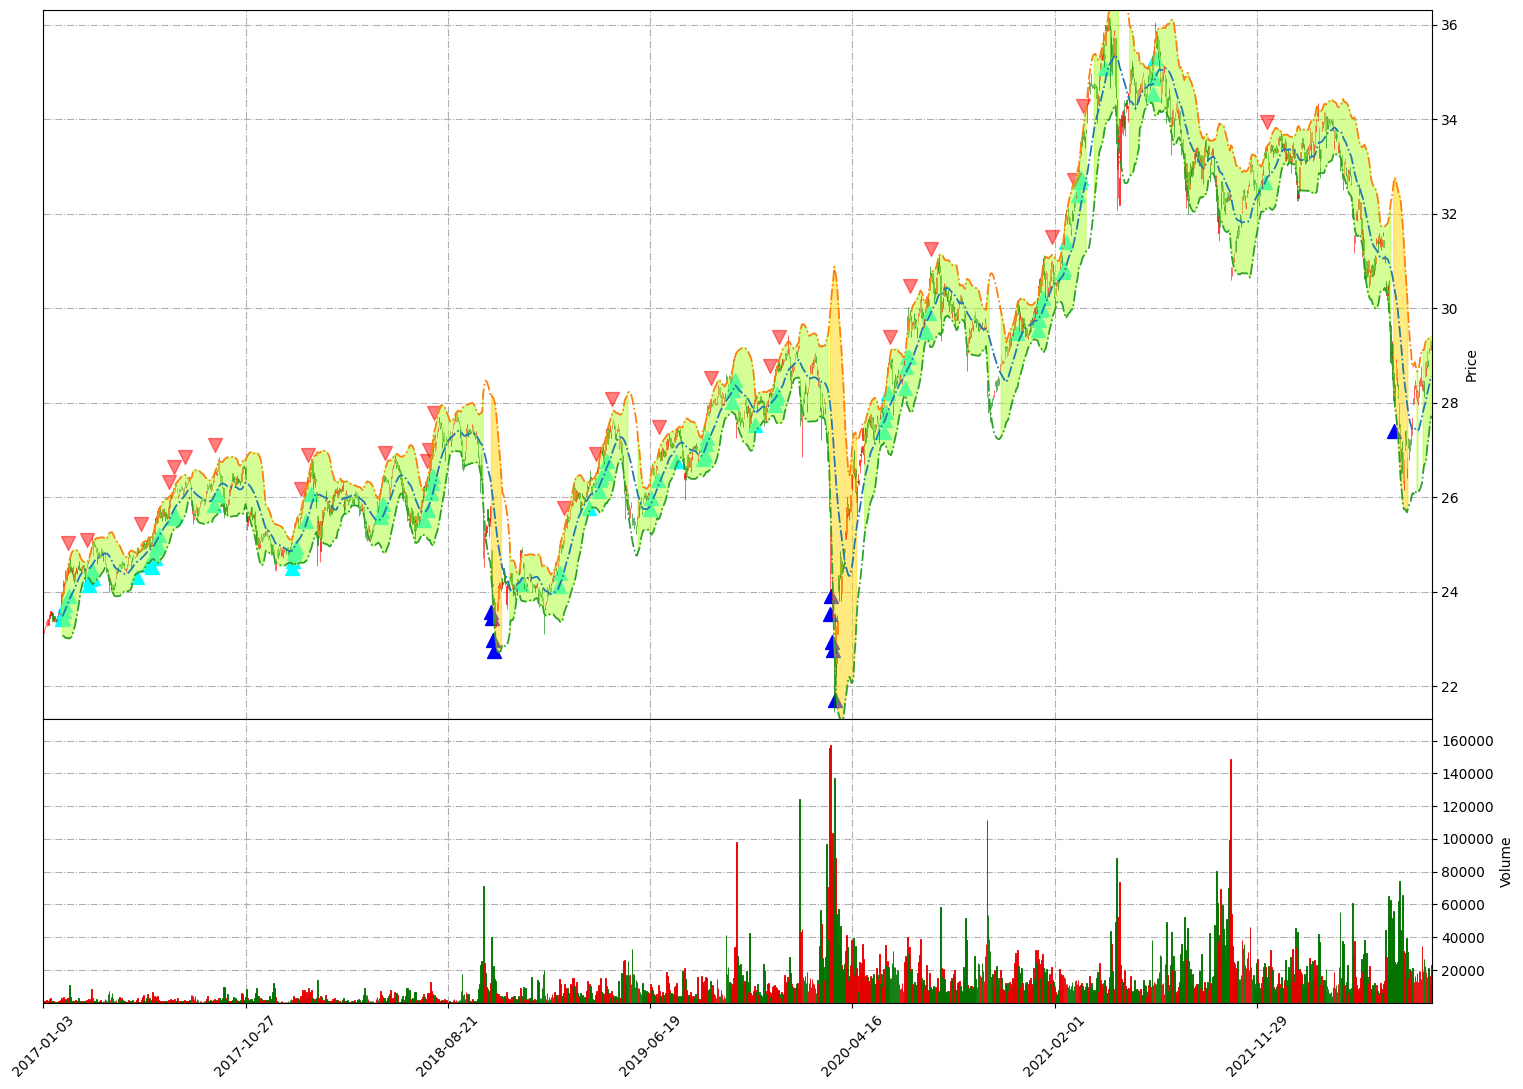

支出： 500000 元
收入： 1077059 元
淨收益： 577059 元
投資報酬率： 115.41 %


In [107]:
import numpy as np
def bbands_rule(_ticker, bb_period=20, bb_stdnum=2, use_detail=False):
    
    # 複製一份資料，避免修改原始資料
    res = _ticker.copy(deep=True)
  
    # 檢查使否存在要用的指標
    try:
        if not {'b_mid', 'b_up', 'b_low'}.issubset(res.columns):
            res = BBands(res, bb_period, bb_stdnum)
    except Exception as e:
        print(e)
        return False

    temp = 0.5                                                                # 設定買賣點的距離
    buy_1 = [np.nan]*len(res)
    buy_2 = [np.nan]*len(res)
    sell_1 = [np.nan]*len(res)
    w_15 = [np.nan]*len(res)
    w_10 = [np.nan]*len(res)
    sell_2 = [np.nan]*len(res)
    new_price = 0                                                                          # 最後進場價格
    buy2 = False                                                                           # 策略二是否進場

    # 取得 index 值(日期)，方便計算使用
    t = res.index

    for i in range(1, len(res)):
        decide = ''
        trade_type = 1                                                                     # 預設交易模式: 分段進出場
        width = res.loc[t[i], 'bband_width']
        slope2 = res.loc[t[i], 'mid_slope']
        # 計算是否符合買進條件
        if width > 15:                                                                     # 策略一: 通道寬度大於15%
            w_15[i] = res.loc[t[i], 'b_low']
            if res.loc[t[i], 'Low'] < res.loc[t[i], 'b_low']:                              # K棒碰觸到下軌
                buy_1[i] = res.loc[t[i], 'Low'] - temp                                     # 標示座標點(深藍色)
                decide = 'buy'
   
        elif width <= 10:                                                                  # 策略二: 通道寬度小於10%
            w_10[i] = res.loc[t[i], 'b_low']                                                                
            if (res.loc[t[i], 'Close'] > res.loc[t[i], 'Open']) and res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:
                buy_2[i] = res.loc[t[i], 'Low'] - temp                                     # 標示座標點(淡藍色)
                new_price = res.loc[t[i], 'Close']
                #print(t[i],'buy2:',slope2,'close:',res.loc[t[i], 'Close'])
                decide = 'buy'
                if slope2 > 0.05:                                                         # 如果20日均線斜率>5%
                    trade_type = 2                                                        # 剩餘金額全數進場
                buy2 = True
                
        # 計算是否符合做空首要條件
        if ((res.loc[t[i], 'b_up']/res.loc[t[i], 'b_low']-1) * 100) > 15: # 通道寬度大於15%
            if res.loc[t[i], 'Close'] > res.loc[t[i], 'b_up']:                            # 收盤價突破上軌
                sell_1[i] = res.loc[t[i], 'High'] + temp
                decide = 'sell'
                buy2 = False
        if buy2 and new_price < res.loc[t[i], 'Close']:
            #print(t[i],bbands_data.loc[t[i], 'b_up'],res.loc[t[i], 'Close'])             # 判斷股價是否離開上軌
            if res.loc[t[i], 'Close'] < res.loc[t[i], 'b_up'] :
                sell_2[i] = res.loc[t[i], 'High'] + temp
                decide = 'sell'
                if slope2 < 0.05:                                                         # 如果20日均線斜率 < 5%
                    trade_type = 2                                                        # 剩餘金額全數出場
                buy2 = False
        
        if use_detail:
            buy_or_sell(t[i].date(), decide, res.loc[t[i], 'Close'],trade_type)                         # 記錄交易資訊
    
    if use_detail:
        decide = 'over'                                                                      #將持有的股數全數出清
        buy_or_sell(t[i].date(), decide, res.loc[t[i], 'Close'])        
    
    res['buy_point'] = buy_1
    res['buy2_point'] = buy_2
    res['sell_point'] = sell_1
    res['sell2_point'] = sell_2
    res['w_15'] = w_15
    res['w_10'] = w_10
    
    return res

# 設定讀取股票資料
import mplfinance as mpf
path = "C:/Users/Landis/Desktop/pystocks"
s = '0056.csv'
SData = pd.read_csv(path+'/'+s,index_col='Date')
SData.index = pd.DatetimeIndex(SData.index) 
# range
day_num = '2017-01-03'                        # 設定顯示股價資訊起始日期
day_end = '2022-08-15'                        # 設定顯示股價資訊結束日期

detail = [['日期', '買/賣(+/-)', '成交價', '價格(稅)', '實際花費', '目前獲利', '剩餘金額', '庫存']]
bbands_data = bbands_rule(SData,use_detail=True)              # 將股價資訊經過BBands函式計算

# 設置k線圖顏色
my_color = mpf.make_marketcolors(up='red',      # 上漲顏色
                                 down='green',  # 下跌顏色
                                 edge='i',      # 隱藏 K 線邊緣
                                 volume='in',   # 成交量用同樣的顏色
                                 inherit=True)  # 繼承其他參數
# 設置圖型呈現
my_style = mpf.make_mpf_style(gridaxis='both',          # 設置網格
                              gridstyle='-.',           # 設定網格花樣
                              y_on_right=True,          # y 座標放右邊
                              marketcolors=my_color)    # 設定k線圖顏色
kwargs = dict(type = 'candle', 
              figscale = 2, # 設定圖型大小
              style = my_style)

# 繪製買賣點圖
bband_line = bbands_data[['b_mid','b_up','b_low']][day_num:day_end]
addplots = [
    mpf.make_addplot(bband_line, panel=0,linestyle='dashdot'),
]
if not bbands_data['buy_point'][day_num:day_end].isnull().all():
    addplots+=[mpf.make_addplot(bbands_data['buy_point'][day_num:day_end], color = 'blue', alpha=1, type='scatter', marker='^', markersize=100)]
if not bbands_data['buy2_point'][day_num:day_end].isnull().all():
    addplots+=[mpf.make_addplot(bbands_data['buy2_point'][day_num:day_end], color = 'cyan', alpha=1, type='scatter', marker='^', markersize=100)]
if not bbands_data['sell_point'][day_num:day_end].isnull().all():
    addplots+=[mpf.make_addplot(bbands_data['sell_point'][day_num:day_end], color = 'darkred', alpha=1, type='scatter', marker='v', markersize=100)]
if not bbands_data['sell2_point'][day_num:day_end].isnull().all():
    addplots+=[mpf.make_addplot(bbands_data['sell2_point'][day_num:day_end], color = 'red', alpha=0.5, type='scatter', marker='v', markersize=100)]

    
# #繪製布林通道
width_15 = dict(y1 = bbands_data['w_15'][day_num:day_end].values,y2 = bbands_data['b_up'][day_num:day_end].values,panel=0,alpha=0.5,color='gold')
width_10 = dict(y1 = bbands_data['w_10'][day_num:day_end].values,y2 = bbands_data['b_up'][day_num:day_end].values,panel=0,alpha=0.5,color='greenyellow')

_panel = 2
mpf.plot(SData.loc[day_num:day_end,:],
         #mav = [10, 60],
         **kwargs,
         num_panels=_panel,           # 設定總層數
         main_panel=0,                # 設定 K 線圖層數
         volume=True,                 # 設定是否繪製成交量 
         volume_panel=_panel - 1,     # 設定成交量層數             
         show_nontrading=False,       # 忽略非交易日
         tight_layout=True,          # 設定是否緊密布局
         datetime_format='%Y-%m-%d',
         addplot = addplots,
         fill_between=[width_15,width_10]
        )
print("支出：", cost, "元")
print("收入：", income, "元")
print("淨收益：", income - cost, "元")
print("投資報酬率：", round(100 * (income - cost) / cost, 2), "%")   # 0056: 115.41 % use sell2

In [98]:
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    display(detail_pd)

,日期,買/賣(+/-),成交價,價格(稅),實際花費,目前獲利,剩餘金額,庫存
0,2017-02-13,+30454,187.5,187.8,-5719261,-499829,171,30454
1,2017-02-15,+0,189.0,189.3,-0,-499829,171,30454
2,2017-02-17,-6091,189.5,189.0,+0,649308,1149308,24363
3,2017-03-21,+5884,195.0,195.3,-1149145,-499837,163,30247
4,2017-04-28,+0,194.5,194.8,-0,-499837,163,30247
5,2017-05-05,-6049,197.5,197.0,+0,689554,1189554,24198
6,2017-05-08,+5865,202.5,202.8,-1189422,-499868,132,30063
7,2017-05-12,-6013,206.0,205.0,+1189422,733329,1233329,24050
8,2017-06-05,+5809,212.0,212.3,-1233251,-499922,78,29859
9,2017-06-08,+0,213.0,213.3,-0,-499922,78,29859


## 參考資料來源:
https://ithelp.ithome.com.tw/articles/10233234  
Day 27 : 股市 K 線 LINE 聊天機器人實作 (功能實作)  
https://ithelp.ithome.com.tw/articles/10241574  